In [1]:
import sys
sys.path.append("/home/luca/Desktop/CM/CM/")
sys.path.append("../../")

import numpy as np
from Network import NR, NC
import src.utils as utils
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier


def plot_stats(conf, dataset, test, net, save=False, log=True, time=False, score=False):
    print(conf)
    net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, log=log)
    if time:
        net.plot_results(f"{dataset}_{test}_loss", score=False, save=save, time=True, log=log)
    if score:
        net.plot_results(f"{dataset}_{test}_score", score=True, save=save, log=log)
        if time:
            net.plot_results(f"{dataset}_{test}_score", score=True, save=save, time=True, log=log)

    net.plot_grad(f"{dataset}_{test}", save=save)
    print(net.best_score())


def plot_comparison(x_datas, y_datas, x_label, y_label, title, loc='best', yscale='log'):
    plt.plot(x_datas[0], y_datas[0], linewidth=2., label='(A1/cm)')
    plt.yscale(yscale)
    plt.grid(True, 'major', 'both', linewidth=0.3)

    plt.plot(x_datas[1], y_datas[1], linewidth=2., label='(A1/nag)')
    plt.yscale(yscale)

    plt.plot(x_datas[2], y_datas[2], linewidth=2., label='(A2)')
    plt.yscale(yscale)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=loc, fontsize=13)
    plt.title(title)
    plt.show()
    plt.clf()
    

def report_plots(params, dataset, net_SGD, net_SGD_nest, net_Adam, score=False, time=False):

    # Conditional configuration
    x_label_time = 'Execution Time'
    x_label_ep = 'Epochs'
    curve_type = 'Objective function' if not score else 'Score'
    title = curve_type + ' comparison - ' + dataset

    train_res_SGD = net_SGD.train_scores if score else net_SGD.train_loss
    train_res_SGD_nest = net_SGD_nest.train_scores if score else net_SGD_nest.train_loss
    train_res_Adam = net_Adam.train_scores if score else net_Adam.train_loss
    x_SGD_time = net_SGD.epochs_time
    x_SGD_ep = list(range(len(train_res_SGD)))
    x_SGD_nest_time = net_SGD_nest.epochs_time
    x_SGD_nest_ep = list(range(len(train_res_SGD_nest)))
    x_Adam_time = net_Adam.epochs_time
    x_Adam_ep = list(range(len(train_res_Adam)))

    if time:
        plot_comparison([x_SGD_time, x_SGD_nest_time, x_Adam_time], 
                      [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                      x_label_time, 
                      curve_type, 
                      title
                     )
    
    plot_comparison([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [train_res_SGD, train_res_SGD_nest, train_res_Adam],
                  x_label_ep, 
                  curve_type, 
                  title
                 )
    
    plot_comparison([x_SGD_ep, x_SGD_nest_ep, x_Adam_ep], 
                  [net_SGD.grad_est_per_epoch, net_SGD_nest.grad_est_per_epoch, net_Adam.grad_est_per_epoch],
                  x_label_ep, 
                  'Gradient norm', 
                  f'Gradient norm comparison - {dataset}',
                  1
                 )

def report_stats(params, dataset, score=False, debug=False):
    if dataset == 'cup':
        nn = NR
        X_train, X_test, y_train, y_test = utils.load_CUP(datasets[dataset])
    else:
        X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])
        nn = NC


    # --- MODEL CONFIGURATIONS ---
    param_SGD = params[dataset]['sgd'].copy()
    param_SGD_nest = params[dataset]['sgd'].copy()
    param_Adam = params[dataset]['adam'].copy()
    
    param_SGD['verbose'] = debug
    net_SGD = nn(**param_SGD)

    param_SGD_nest['verbose'] = debug
    param_SGD_nest['nesterovs_momentum'] = True
    net_SGD_nest = nn(**param_SGD_nest)

    param_Adam['verbose'] = debug
    net_Adam = nn(**param_Adam)   
    # --- MODEL CONFIGURATIONS --- 

    # Train and print best results with given configurations
    net_SGD.fit(X_train, y_train, test_data=(X_test, y_test))
    net_SGD_nest.fit(X_train, y_train, test_data=(X_test, y_test))
    net_Adam.fit(X_train, y_train, test_data=(X_test, y_test))

    print("----- SGD -----")
    print(param_SGD)
    print(net_SGD.best_score(),"\n")
    
    print("----- SGD nesterov-----")
    print(param_SGD_nest)
    print(net_SGD_nest.best_score(),"\n")

    print("----- Adam -----")
    print(param_Adam)
    print(net_Adam.best_score(),"\n")

    return net_SGD, net_SGD_nest, net_Adam


def report_gap_rate(dataset, net_SGD, net_SGD_nest, net_Adam, save=False):
    solver = '(A1/cm)'
    plot_name = f"{dataset}_{solver}"
    net_SGD.plot_gap(dataset, solver, save=save)
    net_SGD.plot_rate(plot_name, save=save)

    solver = '(A1/nag)'
    plot_name = f"{dataset}_{solver}"
    net_SGD_nest.plot_gap(dataset, solver, save=save)
    net_SGD_nest.plot_rate(plot_name, save=save)

    solver = '(A2)'
    plot_name = f"{dataset}_{solver}"
    net_Adam.plot_gap(dataset, solver, save=save)
    net_Adam.plot_rate(plot_name, save=save)


def report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False):
    max_epochs = np.max([len(net_SGD.gap), len(net_SGD_nest.gap), len(net_Adam.gap)])
    epochs = range(max_epochs)

    plot_comparison([epochs, epochs, epochs],
        [net_SGD.gap, net_SGD_nest.gap, net_Adam.gap],
        'Epochs',
        'gap term',
        'Objective function gap comparison - ' + dataset)
    
    
def plotData(data, ylabel, title):
    plt.plot(data)
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
datasets = {
    'cup': '../../data/ML-CUP20-TR.csv',
    'monk1': '../../data/monks-1',
    'monk2': '../../data/monks-2', 
    'monk3': '../../data/monks-3', 
}

params = {
    'cup': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.3,
            'batch_size': None,
            'hidden_layer_sizes': [5, 10],
            'learning_rate_init': 0.01,
            'max_iter': 10000,
            'momentum': 0.5,
            'solver': 'sgd',
            'tol': 1e-08
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.3,
            'batch_size': None,
            'hidden_layer_sizes': [5, 10],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-08
        }
    },
    'monk1': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': 10,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'momentum': 0.9,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [3,5],
            'learning_rate_init': 0.001,
            'max_iter': 10000,
            'solver': "adam",
            'tol': 1e-6,
        }
    },
    'monk2': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': 10,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.1,
            'max_iter': 10000,
            'momentum': 0.5,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [3, 5],
            'learning_rate_init': 0.005,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6
        }
    },
    'monk3': {
        'sgd': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [2, 3],
            'learning_rate_init': 0.1,
            'max_iter': 10000,
            'momentum': 0.5,
            'nesterovs_momentum': False,
            'solver': 'sgd',
            'tol': 1e-06
        },
        'adam': {
            'activation': 'logistic',
            'alpha': 0.001,
            'batch_size': None,
            'hidden_layer_sizes': [2, 3],
            'learning_rate_init': 0.001,
            'max_iter': 10000,
            'solver': 'adam',
            'tol': 1e-6
        }
    }
}

# Testing configuration

In [4]:
def networkStats(net_SGD, net_SGD_nest, net_Adam):
    for net, model in zip([net_SGD, net_SGD_nest, net_Adam], ["SGD", "SGD_nest", "Adam"]):
        weights = net.weights_per_epoch
        grads = net.grads_per_epoch

        mean_grads = []
        for idx in range(net.num_batches-1, len(grads), net.num_batches):
            mean_grads.append(np.mean(grads[idx-net.num_batches+1:idx+1], axis=0))

        for layer in range(len(net.weights)):
            plt.plot([w[layer].mean() for w in weights], label=f"layer {layer}")
        plt.title(f'Weights mean per layer - {model}')
        plt.legend()
        plt.show()

        for layer in range(len(net.weights)):
            plt.plot([w[layer].std() for w in weights], label=f"layer {layer}")
        plt.title(f'Weights std per layer - {model}')
        plt.legend()
        plt.show()

        for layer in range(len(net.weights)):
            plt.plot([g[layer].mean() for g in mean_grads], label=f"layer {layer}")
        plt.title(f'Grads mean per layer - {model}')
        # plt.yscale('log')
        plt.legend()
        plt.show()

        for layer in range(len(net.weights)):
            plt.plot([g[layer].std() for g in mean_grads], label=f"layer {layer}")
        plt.title(f'Grads std per layer - {model}')
        # plt.yscale('log')
        plt.legend()
        plt.show()

        for i, data in enumerate(net.layer_grad_norm):
            mean = np.mean(np.array(data).reshape(-1, net.num_batches), axis=1)    
            plt.plot(mean, label=f'layer {i}')
        plt.title(f"Gradient Norm per layer - {model}")
        plt.legend()
        plt.yscale('log')
        plt.show()

        for i, data in enumerate(net.weights_norm):
            plt.plot(data, label=f"layer {i}")
        plt.legend()
        plt.title(f"Weights norm per layer - {model}")
        plt.yscale('log')
        plt.show()

        for i in range(int(len(net.opti.layer_updates_norm)/2)):
            data = net.opti.layer_updates_norm[i]
            mean = np.mean(np.array(data).reshape(-1, net.num_batches), axis=1)    
            plt.plot(mean, label=f"layer {i}")
        plt.legend()
        plt.title(f"Optimizer updates per layer - {model}")
        plt.yscale('log')
        plt.show()

        plotData(net.loss_noreg, 'loss', f"Loss no reg - {model}")
        plotData(net.reg, 'reg', f'Regularization value  - {model}')
        updates = net.opti.updates_norm
        updates_per_epoch = np.average((np.array(updates)).reshape(-1, int(len(updates)/len(net.train_loss))), axis=1)
        plotData(updates_per_epoch, 'updates norm', f'Updates norm per epoch - {model}')

## Monk1

### Configuration

In [5]:
dataset = 'monk1'
epochs = 10000

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['nesterovs_momentum'] = False
sgd_cm['max_iter'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
sgd_nag['max_iter'] = epochs

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs

monk1 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

X_train, X_test, y_train, y_test = utils.load_monk(datasets['monk1'])

### Sklearn MLPClassifier

In [6]:
monk1['SGD']['batch_size'] = 10
monk1['SGD_nest']['batch_size'] = 10
monk1['Adam']['batch_size'] = 'auto'
model_SGD = MLPClassifier(**monk1['SGD'], random_state=42, n_iter_no_change=100000)
model_SGD_nest = MLPClassifier(**monk1['SGD_nest'], random_state=42, n_iter_no_change=100000)
model_Adam = MLPClassifier(**monk1['Adam'], random_state=42, n_iter_no_change=100000)

model_SGD.fit(X_train, y_train.ravel())
model_SGD_nest.fit(X_train, y_train.ravel())
model_Adam.fit(X_train, y_train.ravel())

c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=[3, 5],
              max_iter=10000, n_iter_no_change=100000, random_state=42,
              tol=1e-06)

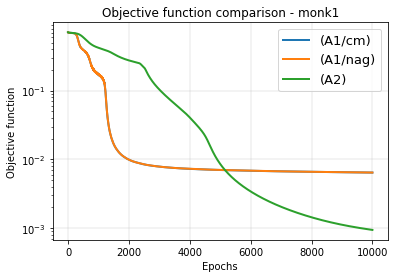

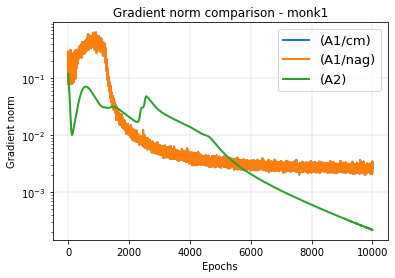

<Figure size 432x288 with 0 Axes>

In [7]:
yscale = 'log'
x_label = 'Epochs'
y_label = 'Objective function'
title = 'Objective function comparison - monk1'
loc='best'
plt.plot(model_SGD.loss_curve_, linewidth=2., label='(A1/cm)')
plt.yscale(yscale)
plt.grid(True, 'major', 'both', linewidth=0.3)

plt.plot(model_SGD_nest.loss_curve_, linewidth=2., label='(A1/nag)')
plt.yscale(yscale)

plt.plot(model_Adam.loss_curve_, linewidth=2., label='(A2)')
plt.yscale(yscale)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(loc=loc, fontsize=13)
plt.title(title)
plt.show()
plt.clf()

yscale = 'log'
x_label = 'Epochs'
y_label = 'Gradient norm'
title = 'Gradient norm comparison - monk1'
loc='best'
plt.plot(model_SGD.grad_est, linewidth=2., label='(A1/cm)')
plt.yscale(yscale)
plt.grid(True, 'major', 'both', linewidth=0.3)

plt.plot(model_SGD_nest.grad_est, linewidth=2., label='(A1/nag)')
plt.yscale(yscale)

plt.plot(model_Adam.grad_est, linewidth=2., label='(A2)')
plt.yscale(yscale)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(loc=loc, fontsize=13)
plt.title(title)
plt.show()
plt.clf()

# plotData(model_SGD.loss_curve_, 'Loss', 'Loss curve SGD - monk1')
# plotData(model_SGD.grad_est, 'Gradient Norm', 'Gradient norm SGD - monk1')

# plotData(model_SGD_nest.loss_curve_, 'Loss', 'Loss curve SGD w/ nesterov - monk1')
# plotData(model_SGD_nest.grad_est, 'Gradient Norm', 'Gradient norm SGD w/ nesterov - monk1')

# plotData(model_Adam.loss_curve_, 'Loss', 'Loss curve Adam - monk1')
# plotData(model_Adam.grad_est, 'Gradient Norm', 'Gradient norm Adam - monk1')

### A1 / A2

In [6]:
dataset = 'monk1'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=False, debug=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1867.67it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: False
Grad: 4.99626e-03 | Loss: 1.29692e-03, 1.01545e-03 | Score:     1, 1    
ended in: 26894.479, avg per ep: 2.6894479
total update: 24008.960999999912, avg updt: 0.20007467499999926
total ff: 150000, total ff time: 4266.376999999986, avg ff: 0.02844251333333324
total bp: 130000, total bp time: 8582.710999999945, avg bp: 0.06602085384615342
total ev: 10000, total ev time: 2446.8009999999954, avg ev: 0.24468009999999954

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 

#### Save and load models

In [6]:
# Saving models
save_param = f"{epochs}_upnorm"
net_Adam.saveModel(f"net_Adam_{save_param}")
net_SGD.saveModel(f"net_SGD_{save_param}")
net_SGD_nest.saveModel(f"net_SGD_nest_{save_param}")

In [7]:
# Loading models
nn = NC
net_SGD = nn(**monk1['SGD'])
net_SGD = net_SGD.loadModel('net_SGD')

FileNotFoundError: [Errno 2] No such file or directory: './res/models/net_SGD.pkl'

#### Network stats

c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


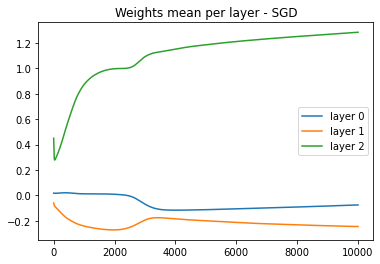

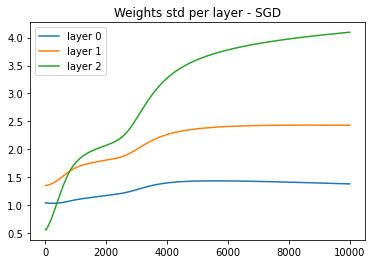

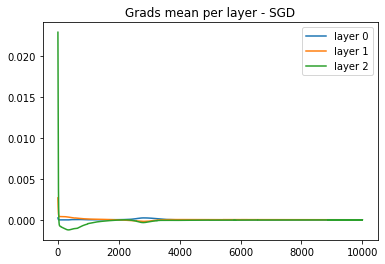

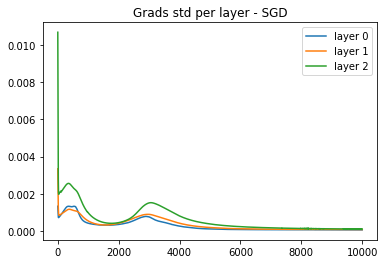

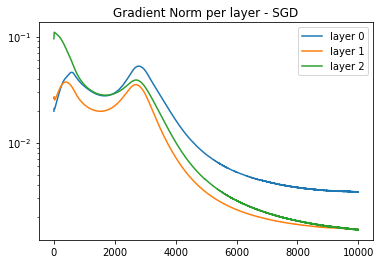

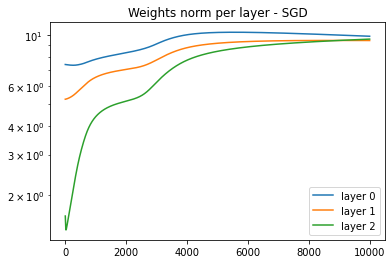

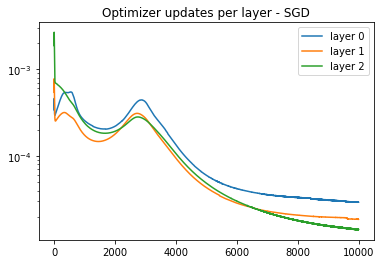

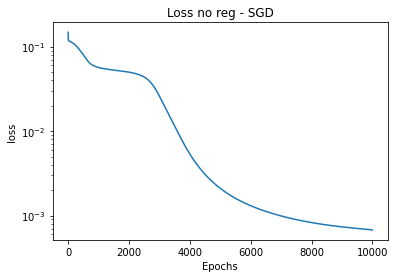

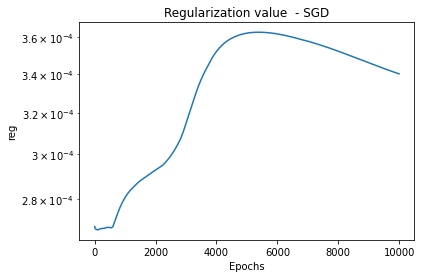

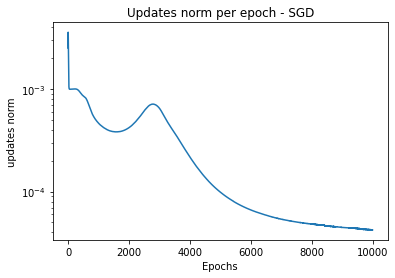

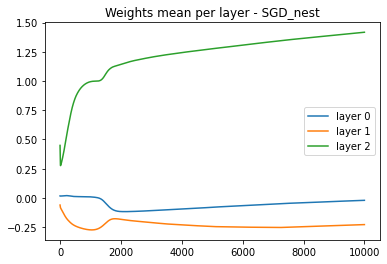

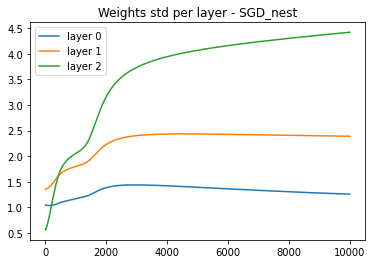

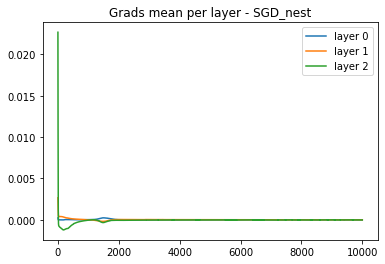

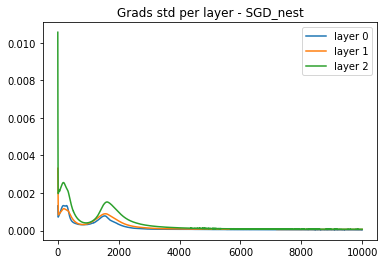

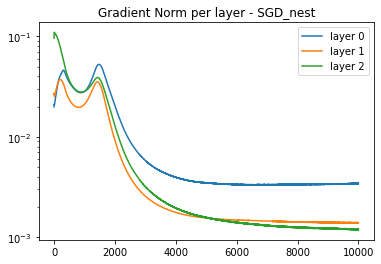

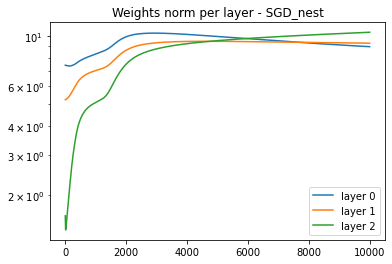

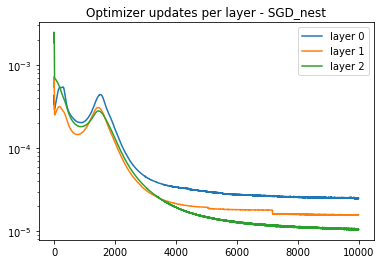

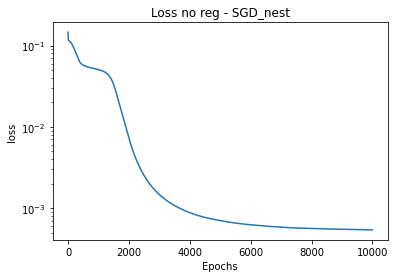

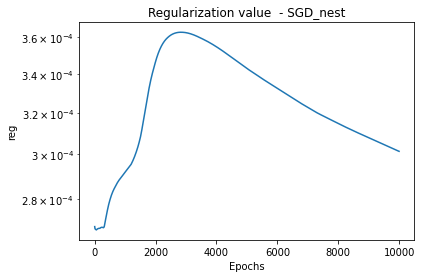

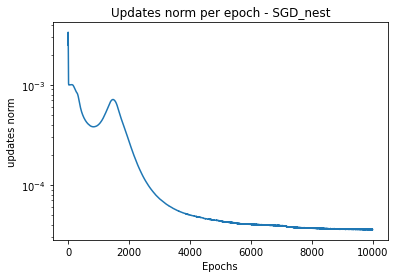

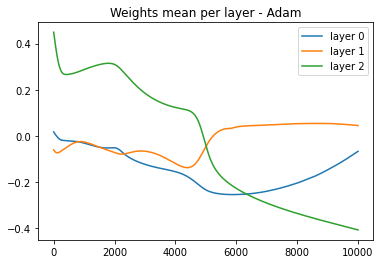

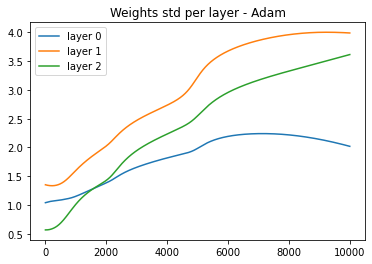

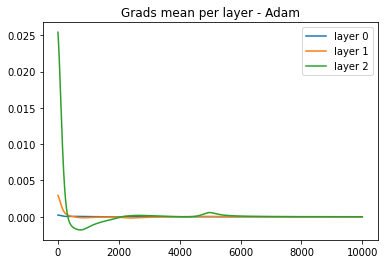

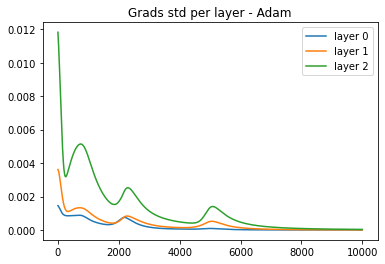

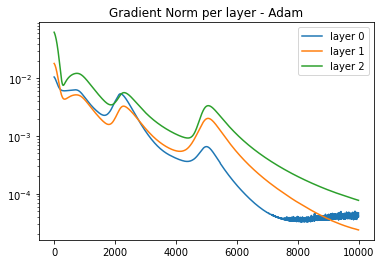

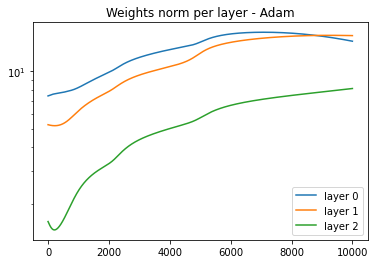

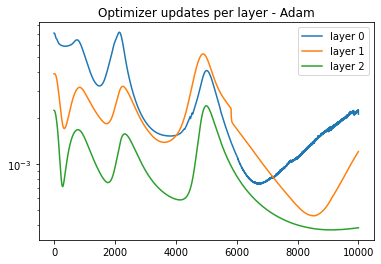

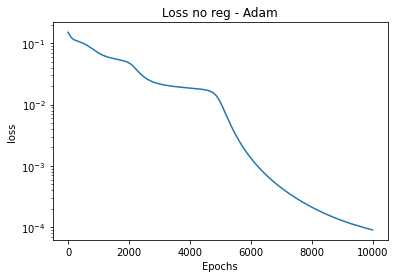

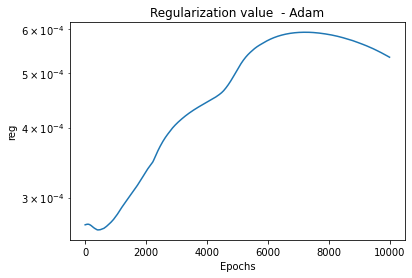

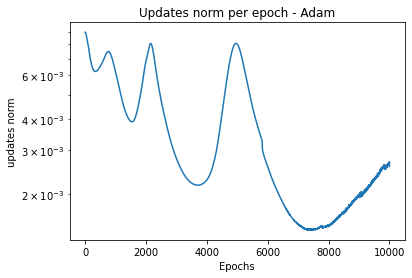

In [7]:
networkStats(net_SGD, net_SGD_nest, net_Adam)

#### Model performances

In [7]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD cm', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD nag', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

----- SGD CM -----


NameError: name 'sgd_cm' is not defined

#### Model comparison

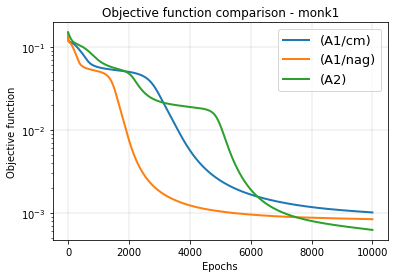

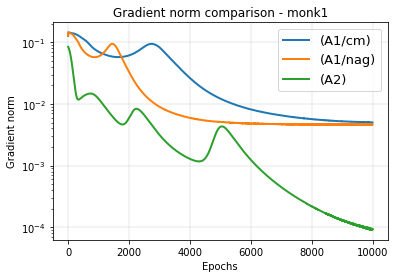

<Figure size 432x288 with 0 Axes>

In [8]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=False)

## Monk2

In [9]:
dataset = 'monk2'
epochs = 10000

sgd_cm = params[dataset]['sgd'].copy()
sgd_cm['max_iter'] = epochs

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
sgd_nag['max_iter'] = epochs

adam = params[dataset]['adam'].copy()
adam['max_iter'] = epochs

monk2 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=False, debug=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1647.13it/s]


----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 2.54680e-03 | Loss: 6.95562e-04, 6.19129e-04 | Score:     1, 1    
ended in: 38475.995, avg per ep: 3.8475995000000003
total update: 34858.60200000001, avg updt: 0.21786626250000007
total ff: 190000, total ff time: 6139.953999999966, avg ff: 0.03231554736842088
total bp: 170000, total bp time: 12202.732999999913, avg bp: 0.07178078235294066
total ev: 10000, total ev time: 3020.301999999996, avg ev: 0.3020301999999996

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol

### A1/A2

#### Save and load models

In [8]:
# Saving models
save_param = f"{dataset}_{epochs}_upnorm"
net_Adam.saveModel(f"net_Adam_{save_param}")
net_SGD.saveModel(f"net_SGD_{save_param}")
net_SGD_nest.saveModel(f"net_SGD_nest_{save_param}")

In [9]:
# Loading models
nn = NC
net_SGD = nn()
net_SGD = net_SGD.loadModel('net_SGD')

#### Execution stats

c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


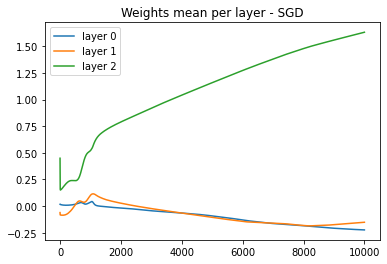

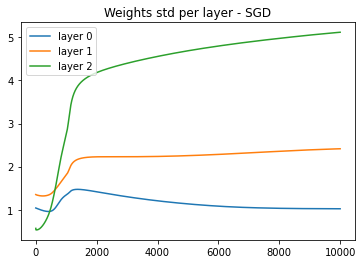

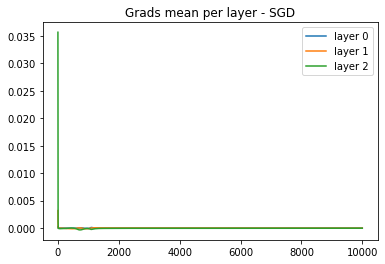

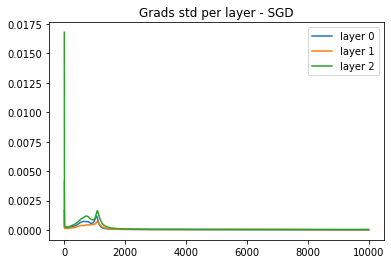

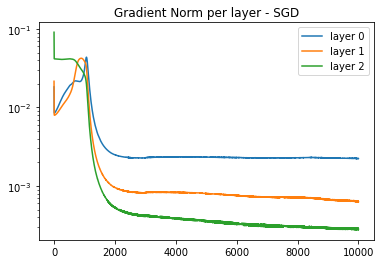

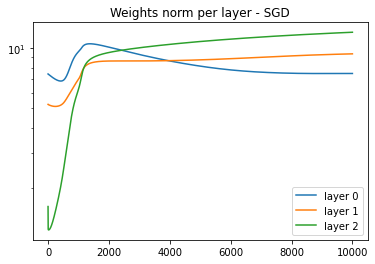

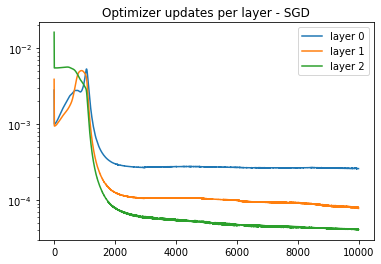

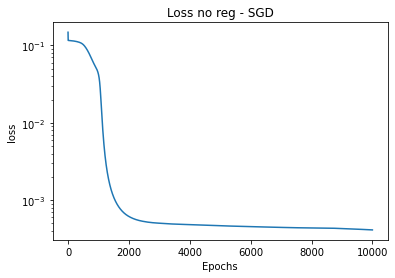

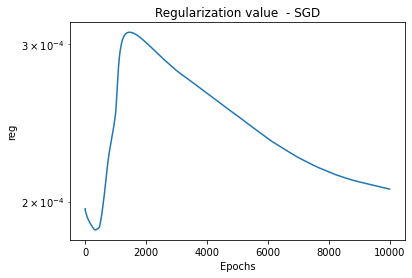

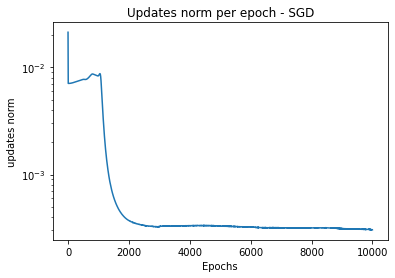

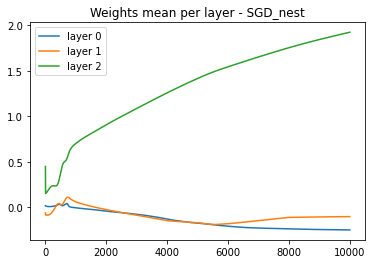

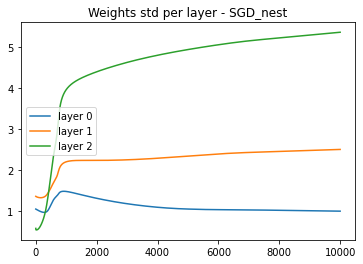

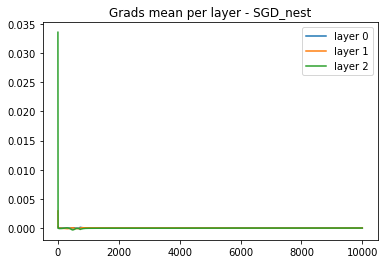

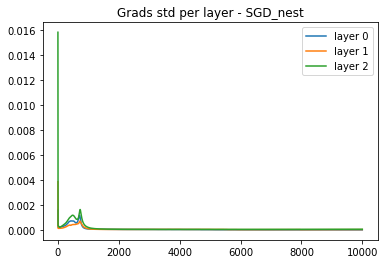

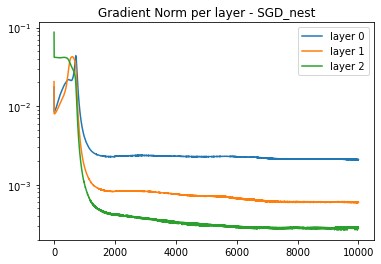

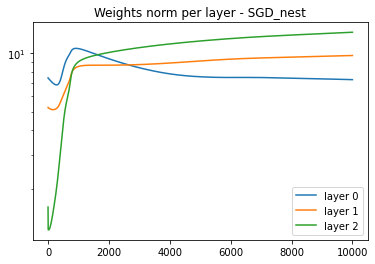

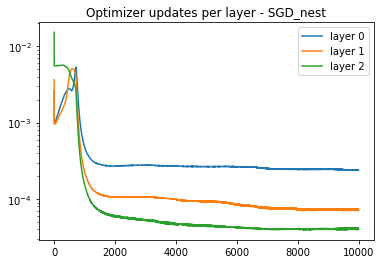

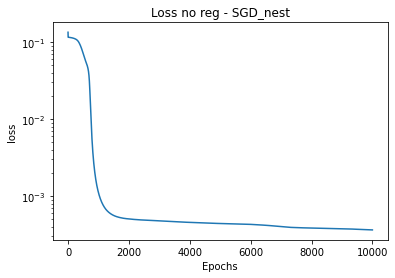

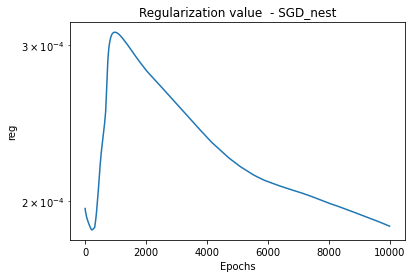

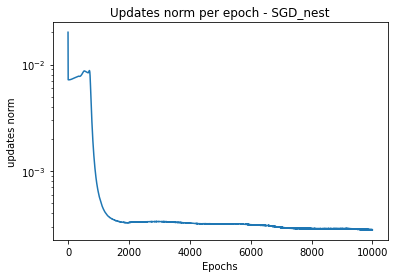

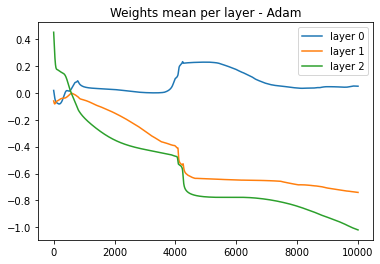

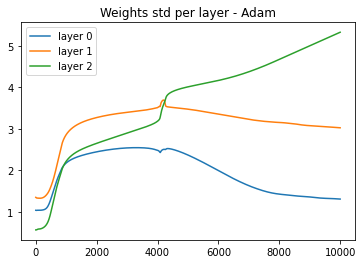

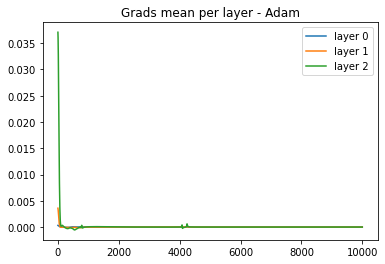

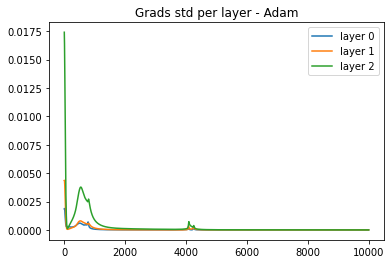

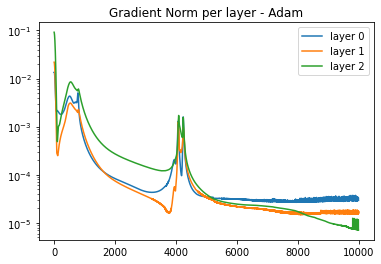

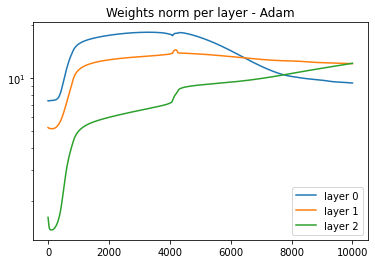

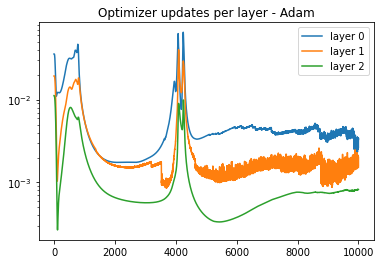

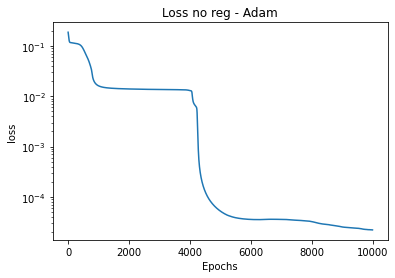

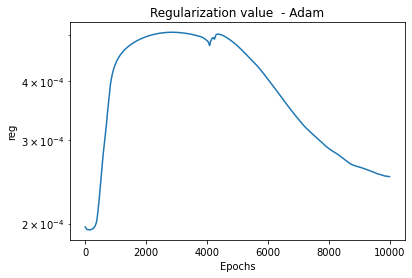

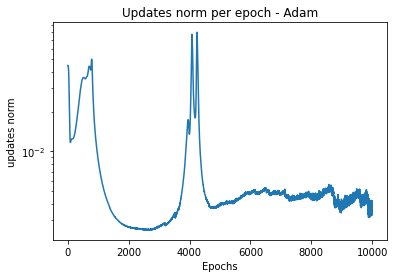

In [10]:
networkStats(net_SGD, net_SGD_nest, net_Adam)

#### Model performances

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06}


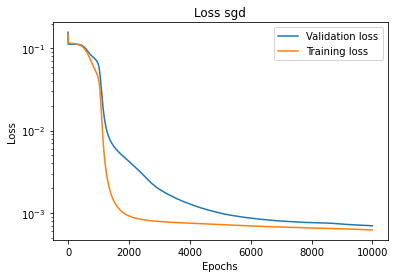

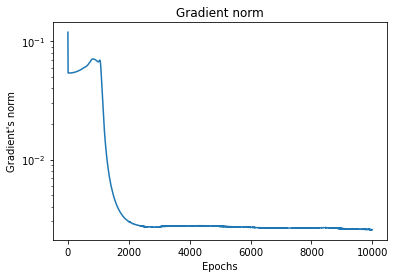

ep: 10000   | s: [3, 5] | b: 10 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 2.54680e-03 | Loss: 6.95562e-04, 6.19129e-04 | Score:     1, 1    
ended in: 33986.441, avg per ep: 3.3986441
total update: 30978.30100000006, avg updt: 0.19361438125000038
total ff: 190000, total ff time: 5277.19700000001, avg ff: 0.027774721052631634
total bp: 170000, total bp time: 10911.19499999996, avg bp: 0.06418349999999977
total ev: 10000, total ev time: 2585.163999999999, avg ev: 0.25851639999999987


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06}


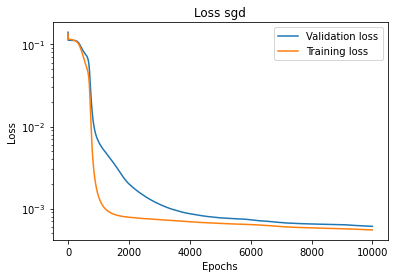

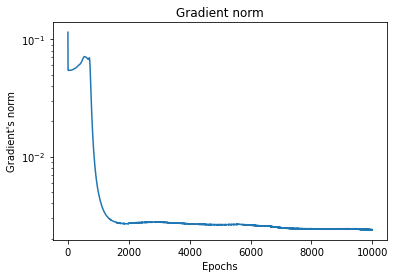

ep: 10000   | s: [3, 5] | b: 10 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: True
Grad: 2.38395e-03 | Loss: 6.08791e-04, 5.50719e-04 | Score:     1, 1    
ended in: 36319.581, avg per ep: 3.6319581
total update: 33321.09000000004, avg updt: 0.20825681250000025
total ff: 190000, total ff time: 5326.517999999991, avg ff: 0.02803430526315785
total bp: 170000, total bp time: 11111.348999999882, avg bp: 0.06536087647058754
total ev: 10000, total ev time: 2567.1530000000034, avg ev: 0.25671530000000037


----- Adam -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'solver': 'adam', 'tol': 1e-06}


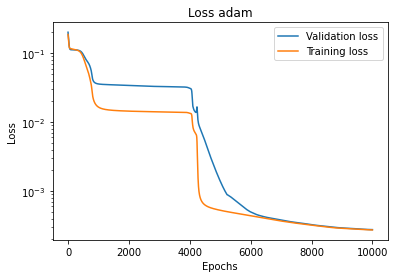

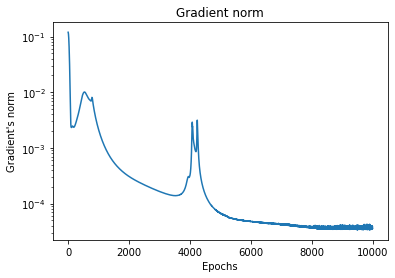

ep: 10000   | s: [3, 5] | b: 169 | e:0.005 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 3.52730e-05 | Loss: 2.76127e-04, 2.73373e-04 | Score:     1, 1    
ended in: 5531.89, avg per ep: 0.553189
total update: 2980.377999999996, avg updt: 0.29803779999999963
total ff: 30000, total ff time: 1536.243000000001, avg ff: 0.051208100000000034
total bp: 10000, total bp time: 1086.1370000000002, avg bp: 0.10861370000000002
total ev: 10000, total ev time: 2282.495, avg ev: 0.2282495




<Figure size 432x288 with 0 Axes>

In [29]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

#### Model comparison

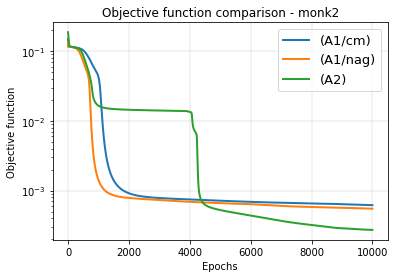

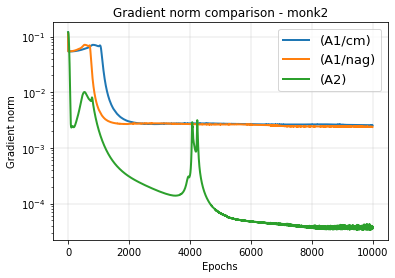

<Figure size 432x288 with 0 Axes>

In [11]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=False)

## Monk3

In [12]:
dataset = 'monk3'    

sgd_cm = params[dataset]['sgd'].copy()

sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True

adam = params[dataset]['adam'].copy()

monk3 = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}

net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=False, debug=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1948.20it/s]


----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [2, 3] | b: 122 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 1.26598e-03 | Loss: 2.20160e-02, 2.85011e-02 | Score: 0.972, 0.934
ended in: 4826.975, avg per ep: 0.48269750000000006
total update: 2270.151999999997, avg updt: 0.2270151999999997
total ff: 30000, total ff time: 1398.2259999999994, avg ff: 0.04660753333333331
total bp: 10000, total bp time: 870.0420000000008, avg bp: 0.08700420000000009
total ev: 10000, total ev time: 2255.7349999999983, avg ev: 0.22557349999999984

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 

### Sklearn

In [6]:
X_train, X_test, y_train, y_test = utils.load_monk(datasets[dataset])

monk3['SGD']['batch_size'] = 'auto'
monk3['SGD_nest']['batch_size'] = 'auto'
monk3['Adam']['batch_size'] = 'auto'
model_SGD = MLPClassifier(**monk3['SGD'], random_state=42, n_iter_no_change=50000)
model_SGD_nest = MLPClassifier(**monk3['SGD_nest'], random_state=42, n_iter_no_change=500000)
model_Adam = MLPClassifier(**monk3['Adam'], random_state=42, n_iter_no_change=500000)

model_SGD.fit(X_train, y_train.ravel())
model_SGD_nest.fit(X_train, y_train.ravel())
model_Adam.fit(X_train, y_train.ravel())

c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:708: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', alpha=0.01, hidden_layer_sizes=[20, 30],
              max_iter=50000, n_iter_no_change=500000, random_state=42,
              tol=1e-06)

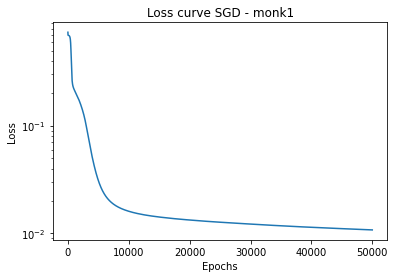

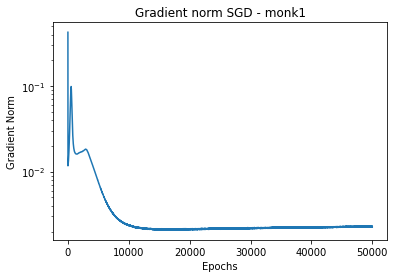

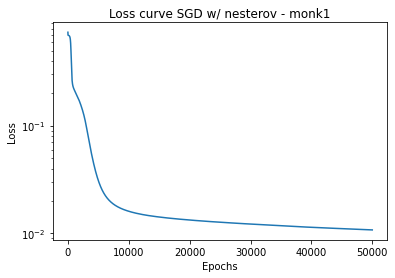

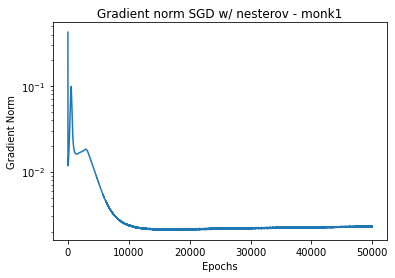

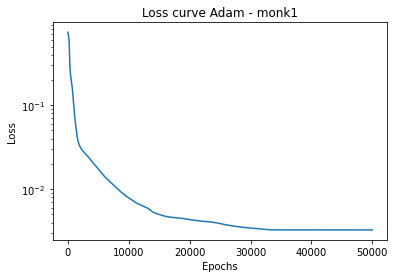

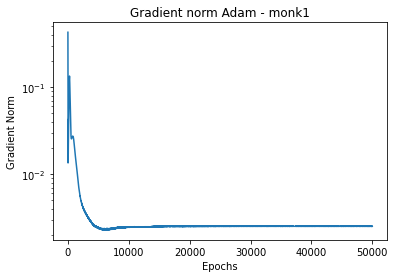

In [7]:
plotData(model_SGD.loss_curve_, 'Loss', 'Loss curve SGD - monk1')
plotData(model_SGD.grad_est, 'Gradient Norm', 'Gradient norm SGD - monk1')

plotData(model_SGD_nest.loss_curve_, 'Loss', 'Loss curve SGD w/ nesterov - monk1')
plotData(model_SGD_nest.grad_est, 'Gradient Norm', 'Gradient norm SGD w/ nesterov - monk1')

plotData(model_Adam.loss_curve_, 'Loss', 'Loss curve Adam - monk1')
plotData(model_Adam.grad_est, 'Gradient Norm', 'Gradient norm Adam - monk1')

### A1/A2

#### Save and load models

In [8]:
# Saving models
save_param = f"{dataset}_{epochs}_upnorm"
net_Adam.saveModel(f"net_Adam_{save_param}")
net_SGD.saveModel(f"net_SGD_{save_param}")
net_SGD_nest.saveModel(f"net_SGD_nest_{save_param}")

In [9]:
# Loading models
nn = NC
net_SGD = nn()
net_SGD = net_SGD.loadModel('net_SGD')

#### Execution stats

c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


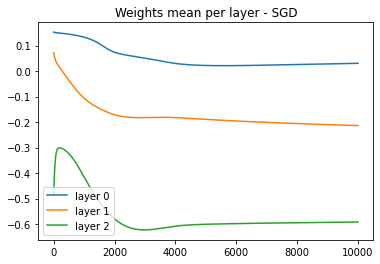

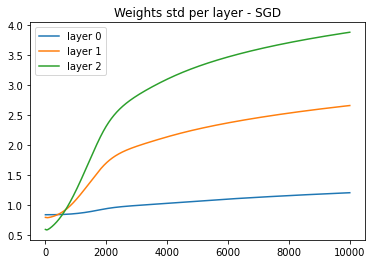

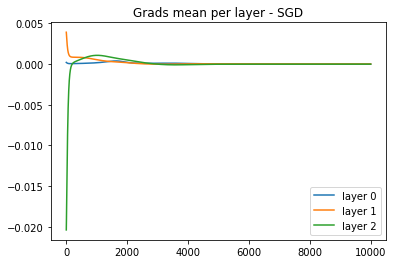

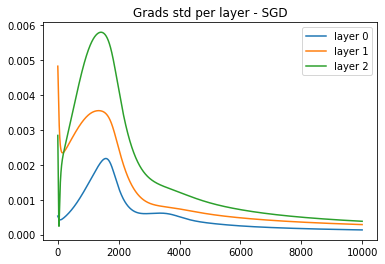

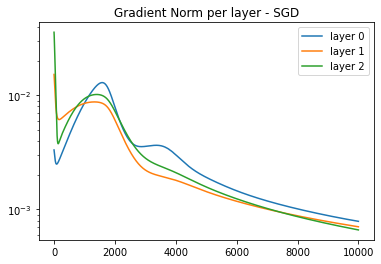

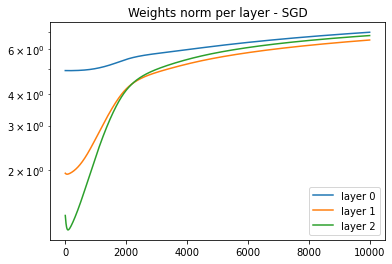

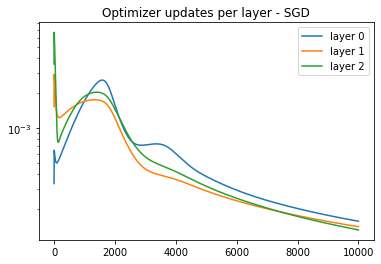

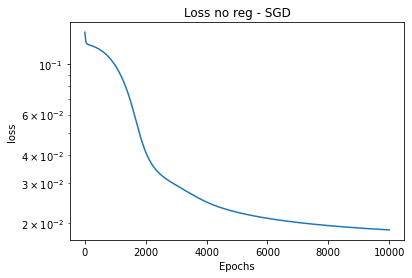

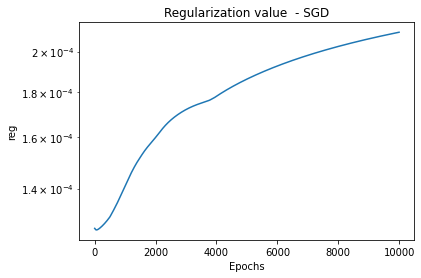

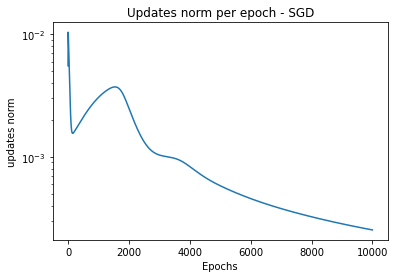

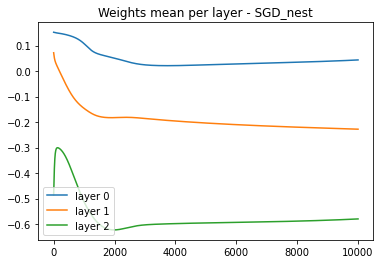

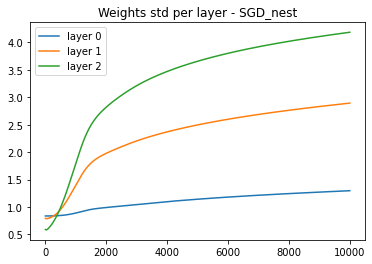

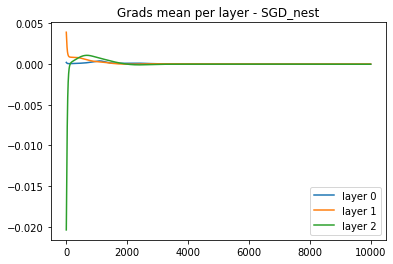

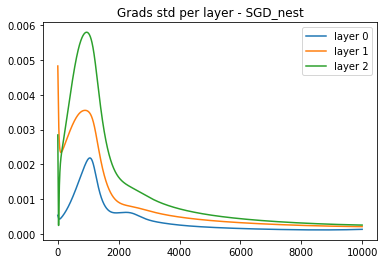

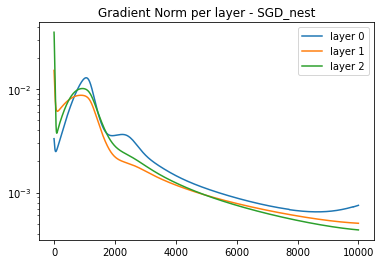

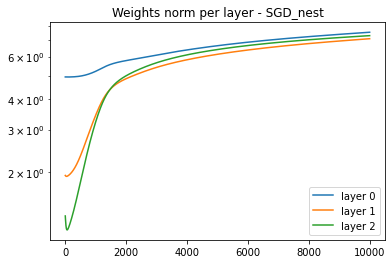

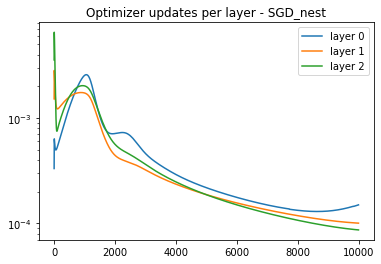

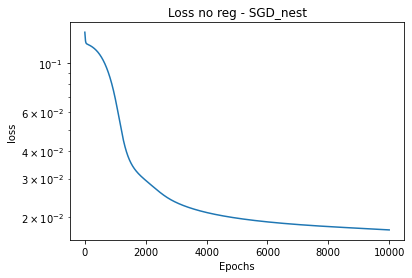

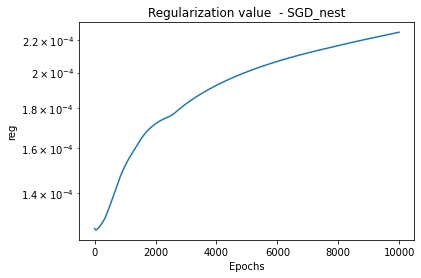

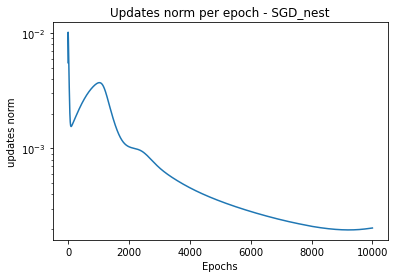

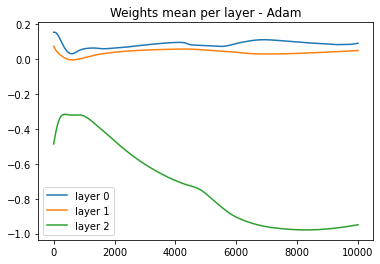

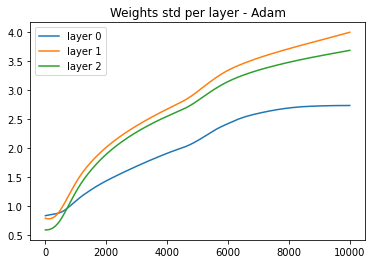

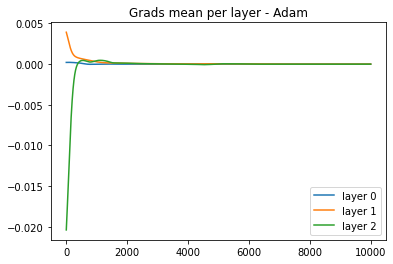

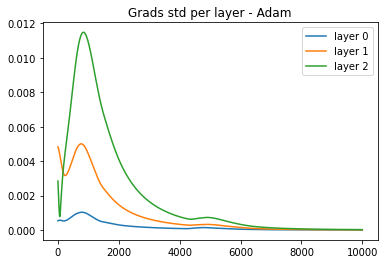

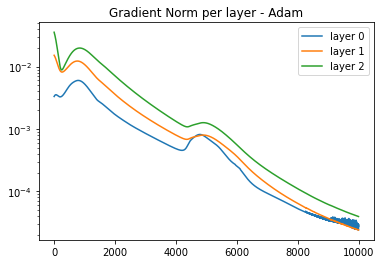

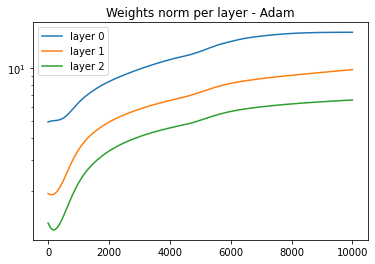

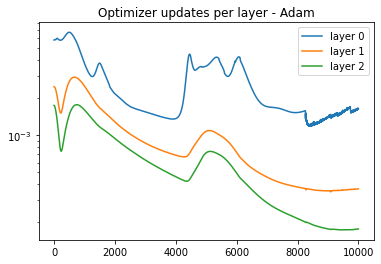

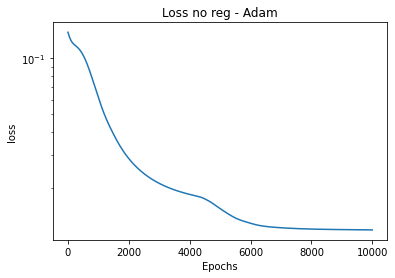

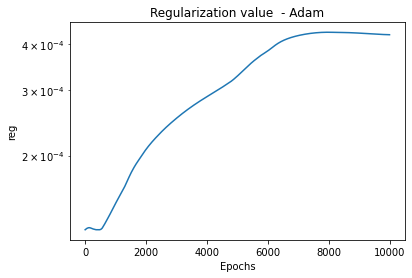

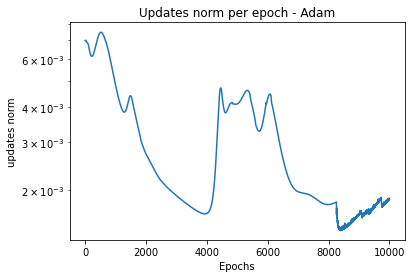

In [13]:
networkStats(net_SGD, net_SGD_nest, net_Adam)

#### Model performances

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06}


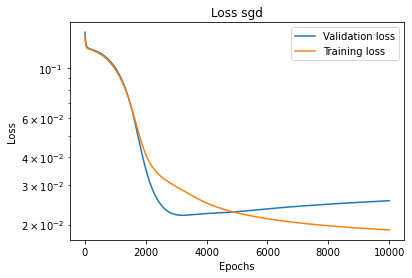

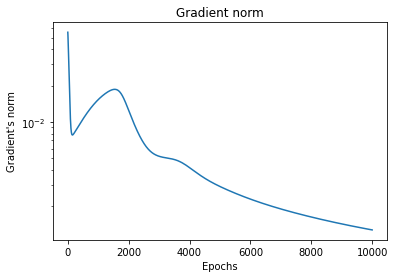

ep: 10000   | s: [2, 3] | b: 122 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 1.26598e-03 | Loss: 2.20160e-02, 2.85011e-02 | Score: 0.972, 0.934
ended in: 4824.491, avg per ep: 0.4824491
total update: 2328.2610000000036, avg updt: 0.23282610000000037
total ff: 30000, total ff time: 1491.1849999999977, avg ff: 0.049706166666666586
total bp: 10000, total bp time: 866.1859999999999, avg bp: 0.08661859999999999
total ev: 10000, total ev time: 2245.0710000000017, avg ev: 0.22450710000000018


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-06}


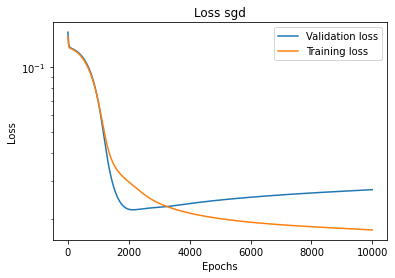

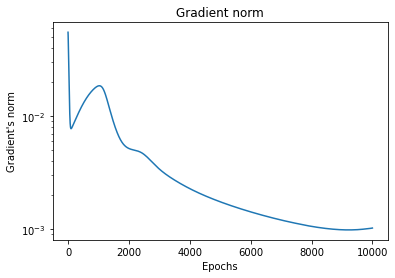

ep: 10000   | s: [2, 3] | b: 122 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: True
Grad: 1.02089e-03 | Loss: 2.20140e-02, 2.84996e-02 | Score: 0.972, 0.934
ended in: 4961.284, avg per ep: 0.49612839999999997
total update: 2431.0950000000016, avg updt: 0.24310950000000017
total ff: 30000, total ff time: 1555.1309999999983, avg ff: 0.051837699999999945
total bp: 10000, total bp time: 842.0320000000008, avg bp: 0.08420320000000009
total ev: 10000, total ev time: 2306.9320000000025, avg ev: 0.23069320000000026


----- Adam -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.001, 'max_iter': 10000, 'solver': 'adam', 'tol': 1e-06}


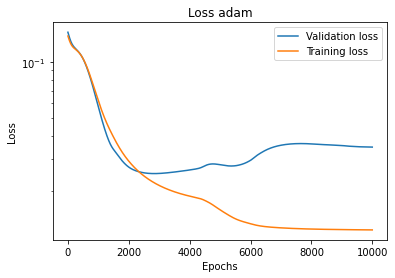

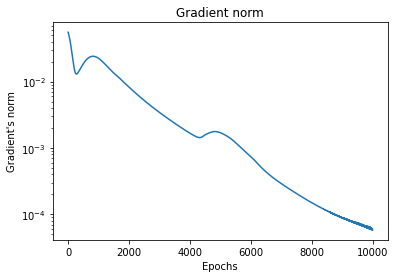

ep: 10000   | s: [2, 3] | b: 122 | e:0.001 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 5.84450e-05 | Loss: 2.49022e-02, 2.22038e-02 | Score: 0.972, 0.934
ended in: 5204.417, avg per ep: 0.5204417
total update: 2552.7389999999978, avg updt: 0.2552738999999998
total ff: 30000, total ff time: 1598.7529999999986, avg ff: 0.05329176666666662
total bp: 10000, total bp time: 836.1569999999996, avg bp: 0.08361569999999996
total ev: 10000, total ev time: 2389.2350000000015, avg ev: 0.23892350000000015




<Figure size 432x288 with 0 Axes>

In [21]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

#### Model comparison

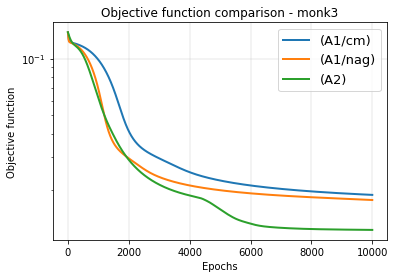

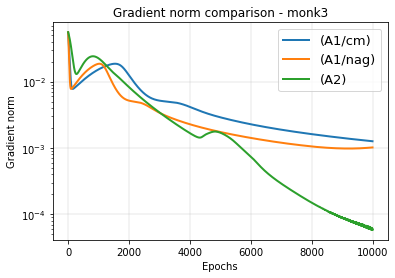

<Figure size 432x288 with 0 Axes>

In [14]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=False)

## CUP

In [15]:
dataset = 'cup'

sgd_cm = params[dataset]['sgd'].copy()
sgd_nag = sgd_cm.copy()
sgd_nag['nesterovs_momentum'] = True
adam = params[dataset]['adam'].copy()

cup = {
    'SGD': sgd_cm,
    'SGD_nest': sgd_nag,
    'Adam': adam
}
    
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=False, debug=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:16<00:00, 616.08it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False}
ep: 10000   | s: [5, 10] | b: 1066 | e: 0.01 | alpha:  0.3 | m:  0.5 | nesterovs_momentum: False
Grad: 4.20771e-02 | Loss: 4.16183e+00, 3.22065e+00 | Score: 0.939, 0.951
ended in: 15291.775, avg per ep: 1.5291774999999999
total update: 6321.664999999936, avg updt: 0.6321664999999936
total ff: 30000, total ff time: 4759.325999999965, avg ff: 0.15864419999999882
total bp: 10000, total bp time: 3203.1489999999894, avg bp: 0.32031489999999896
total ev: 10000, total ev time: 8580.664999999919, avg ev: 0.8580664999999918

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False, 'nesterovs_momentum': Tru

### A1/A2

#### Save and load models

In [8]:
# Saving models
save_param = f"{dataset}_{epochs}_upnorm"
net_Adam.saveModel(f"net_Adam_{save_param}")
net_SGD.saveModel(f"net_SGD_{save_param}")
net_SGD_nest.saveModel(f"net_SGD_nest_{save_param}")

In [9]:
# Loading models
nn = NC
net_SGD = nn()
net_SGD = net_SGD.loadModel('net_SGD')

#### Execution stats

c:\users\ulfhe\.virtualenvs\cm-qlivexgb\lib\site-packages\numpy\core\_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


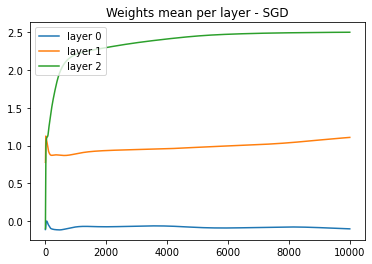

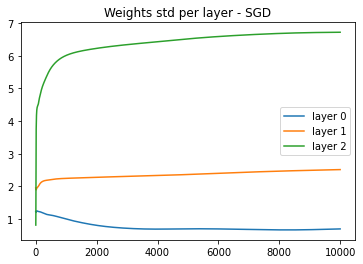

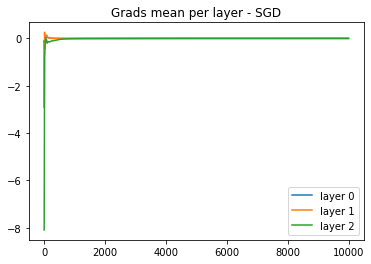

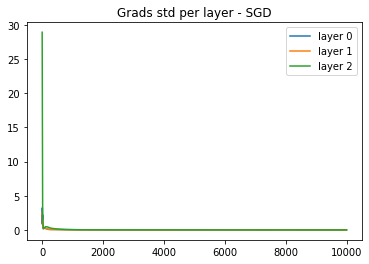

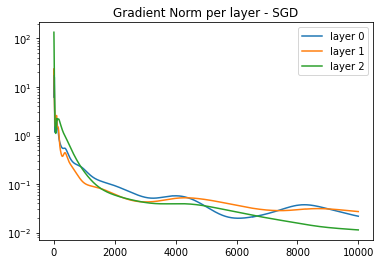

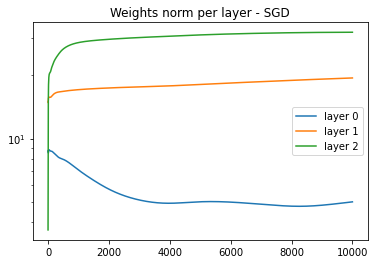

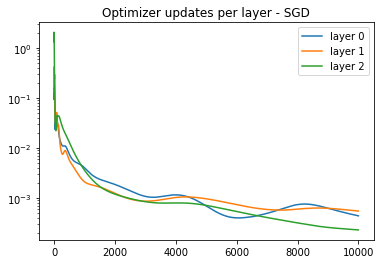

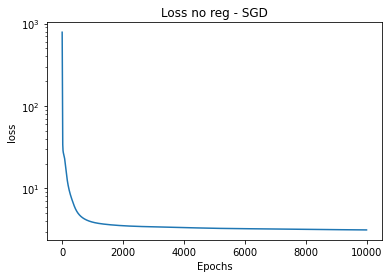

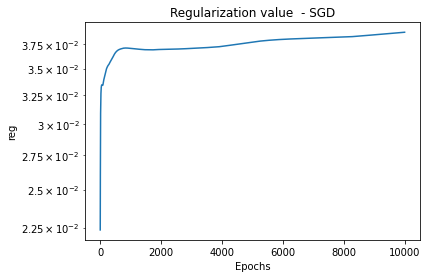

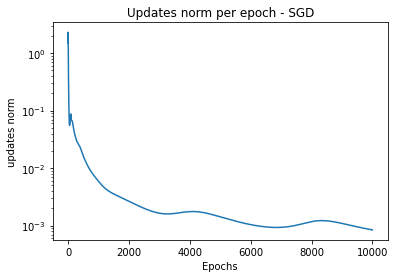

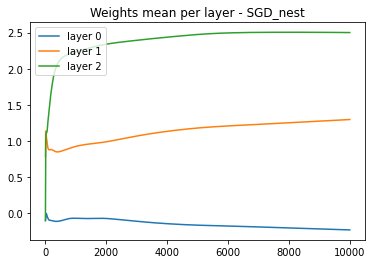

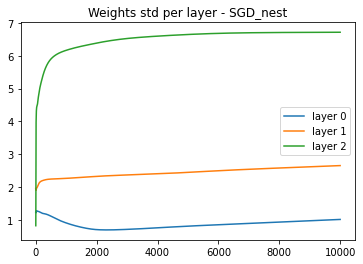

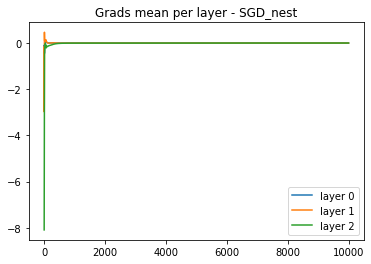

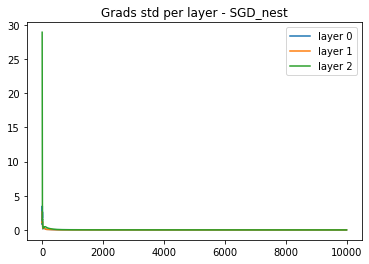

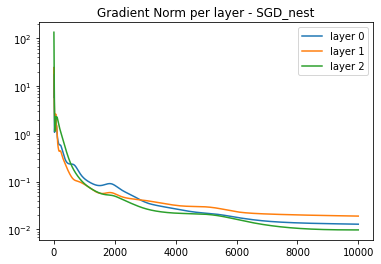

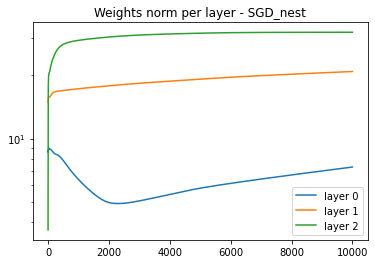

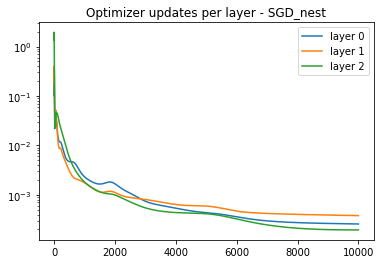

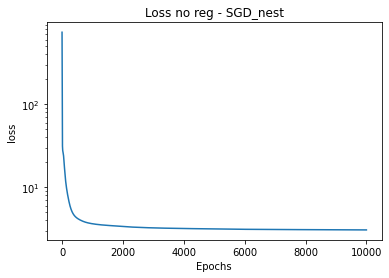

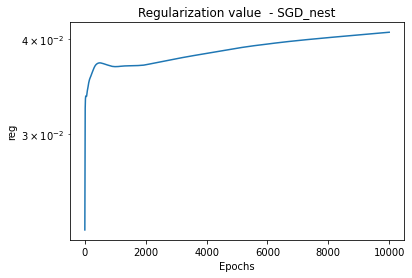

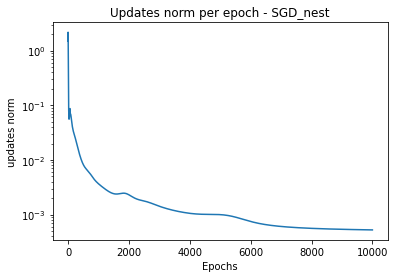

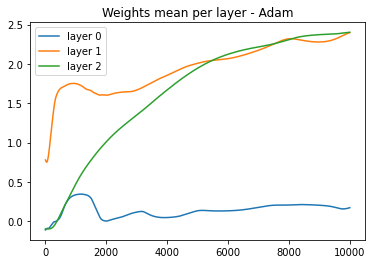

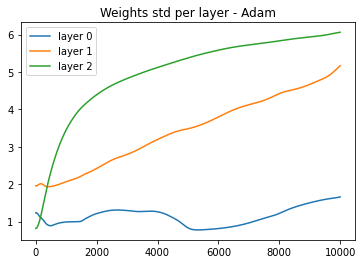

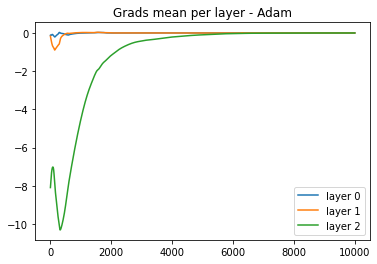

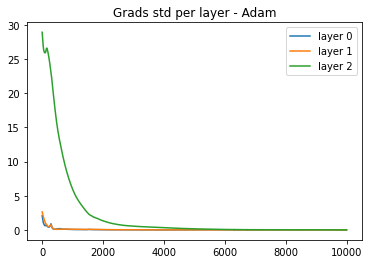

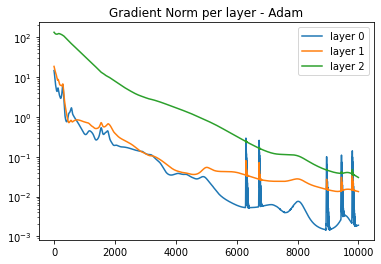

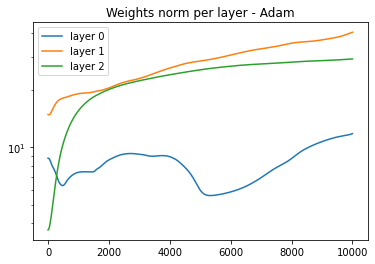

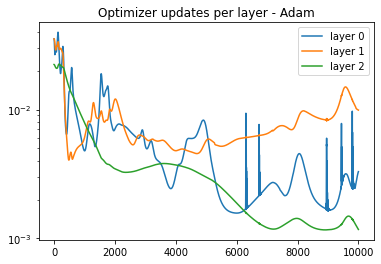

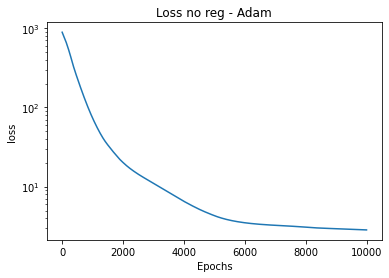

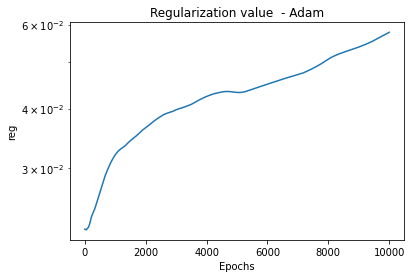

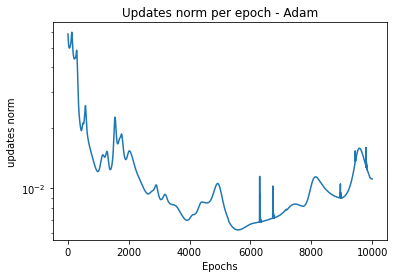

In [16]:
networkStats(net_SGD, net_SGD_nest, net_Adam)

#### Model performances

----- SGD CM -----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08}


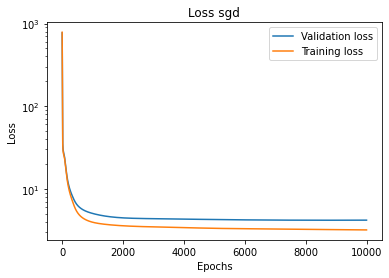

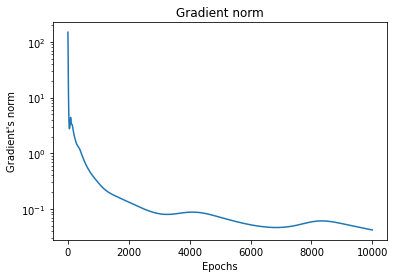

ep: 10000   | s: [5, 10] | b: 1066 | e: 0.01 | alpha:  0.3 | m:  0.5 | nesterovs_momentum: False
Grad: 4.20771e-02 | Loss: 4.16183e+00, 3.22065e+00 | Score: 0.939, 0.951
ended in: 14087.686, avg per ep: 1.4087686
total update: 5709.912999999983, avg updt: 0.5709912999999983
total ff: 30000, total ff time: 4581.359999999986, avg ff: 0.15271199999999954
total bp: 10000, total bp time: 3084.335, avg bp: 0.3084335
total ev: 10000, total ev time: 8199.798999999904, avg ev: 0.8199798999999904


----- SGD NAG -----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'nesterovs_momentum': True}


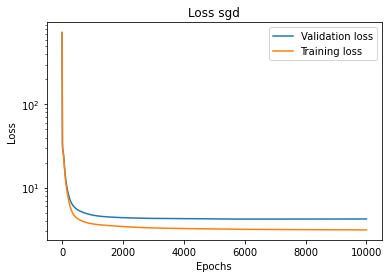

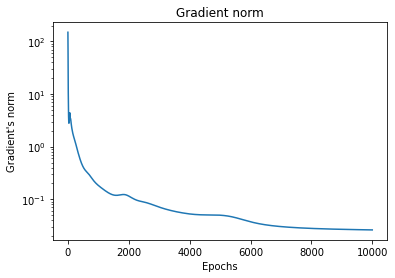

ep: 10000   | s: [5, 10] | b: 1066 | e: 0.01 | alpha:  0.3 | m:  0.5 | nesterovs_momentum: True
Grad: 2.62174e-02 | Loss: 4.19121e+00, 3.15686e+00 | Score: 0.938, 0.952
ended in: 13962.715, avg per ep: 1.3962715
total update: 5751.301999999959, avg updt: 0.5751301999999959
total ff: 30000, total ff time: 4413.493999999988, avg ff: 0.14711646666666625
total bp: 10000, total bp time: 3007.115999999996, avg bp: 0.3007115999999996
total ev: 10000, total ev time: 8034.035999999896, avg ev: 0.8034035999999897


----- Adam -----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.005, 'max_iter': 10000, 'solver': 'adam', 'tol': 1e-08}


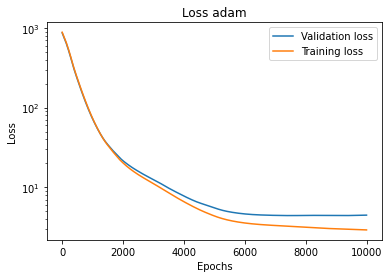

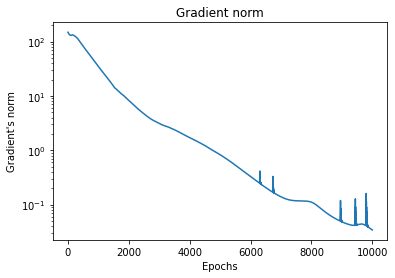

ep: 10000   | s: [5, 10] | b: 1066 | e:0.005 | alpha:  0.3 | m:  0.5 | nesterovs_momentum: False
Grad: 3.43867e-02 | Loss: 4.39915e+00, 3.22036e+00 | Score: 0.936, 0.952
ended in: 13853.381, avg per ep: 1.3853381
total update: 5856.3509999999715, avg updt: 0.5856350999999972
total ff: 30000, total ff time: 4376.501999999985, avg ff: 0.1458833999999995
total bp: 10000, total bp time: 2896.5489999999963, avg bp: 0.28965489999999966
total ev: 10000, total ev time: 7840.700999999967, avg ev: 0.7840700999999968




<Figure size 432x288 with 0 Axes>

In [23]:
print("----- SGD CM -----")
plot_stats(sgd_cm, dataset, 'SGD', net_SGD)
print("----- SGD NAG -----")
plot_stats(sgd_nag, dataset, 'SGD', net_SGD_nest)
print("----- Adam -----")
plot_stats(adam, dataset, 'Adam', net_Adam)

#### Model comparison

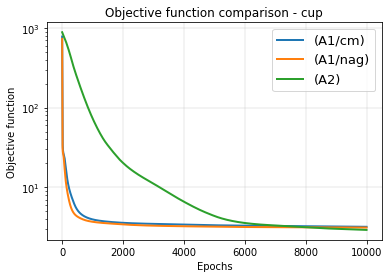

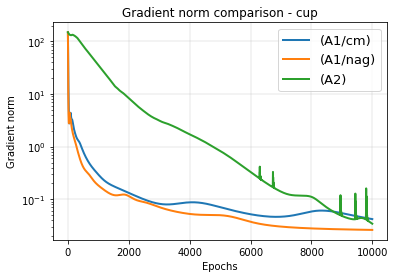

<Figure size 432x288 with 0 Axes>

In [17]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=False)

# Report stats

In [4]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': (8, 6)})

## Monk1

In [4]:
debug = False
score = False
dataset = 'monk1'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:04<00:00, 2156.87it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:0.005 | alpha:0.001 | m:  0.9 | nesterovs_momentum: False
Grad: 4.99626e-03 | Loss: 1.29692e-03, 1.01545e-03 | Score:     1, 1    
ended in: 21636.96, avg per ep: 2.163696
total update: 18838.824999999946, avg updt: 0.15699020833333288
total ff: 150000, total ff time: 4912.355999999981, avg ff: 0.03274903999999987
total bp: 130000, total bp time: 9025.25099999994, avg bp: 0.06942500769230724
total ev: 10000, total ev time: 2596.3179999999984, avg ev: 0.25963179999999986

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.005, 'max_iter': 10000, 'momentum': 0.9, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e-

### Loss comparison

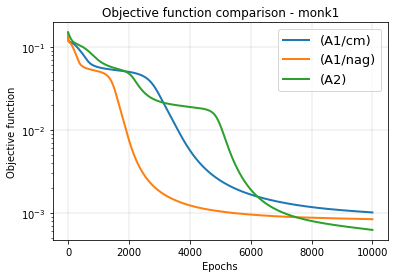

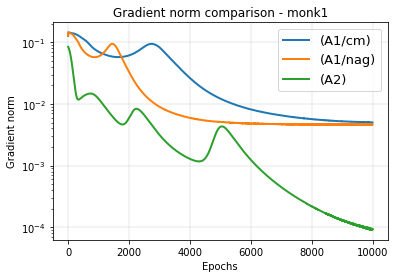

<Figure size 432x288 with 0 Axes>

In [5]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

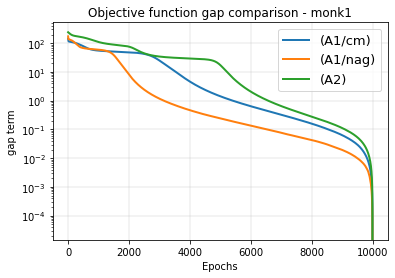

<Figure size 432x288 with 0 Axes>

In [6]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## Monk2

In [6]:
debug = False
score = False
dataset = 'monk2'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:05<00:00, 1974.33it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [3, 5] | b: 10 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 2.54680e-03 | Loss: 6.95562e-04, 6.19129e-04 | Score:     1, 1    
ended in: 26114.523, avg per ep: 2.6114523000000003
total update: 23365.74099999994, avg updt: 0.14603588124999964
total ff: 190000, total ff time: 5348.571999999969, avg ff: 0.02815037894736826
total bp: 170000, total bp time: 11215.119999999932, avg bp: 0.06597129411764666
total ev: 10000, total ev time: 2535.271999999997, avg ev: 0.25352719999999973

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 10, 'hidden_layer_sizes': [3, 5], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'to

### Loss comparison

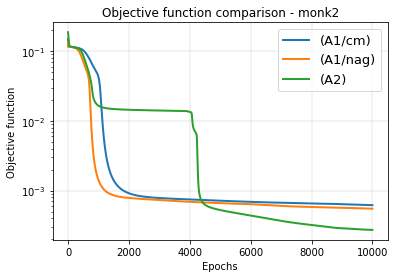

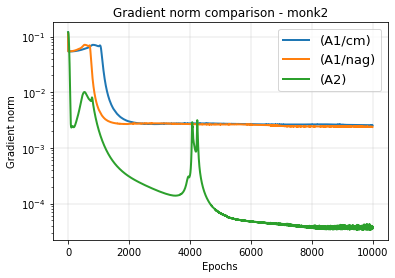

<Figure size 432x288 with 0 Axes>

In [7]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

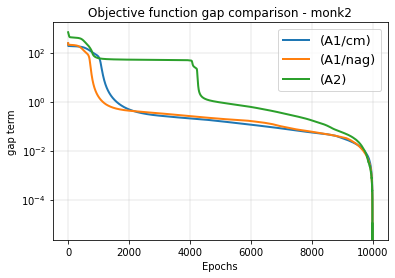

<Figure size 432x288 with 0 Axes>

In [9]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## Monk3

In [8]:
debug = False
score = False
dataset = 'monk3'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:04<00:00, 2283.63it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': False, 'solver': 'sgd', 'tol': 1e-06, 'verbose': False}
ep: 10000   | s: [2, 3] | b: 122 | e:  0.1 | alpha:0.001 | m:  0.5 | nesterovs_momentum: False
Grad: 1.26598e-03 | Loss: 2.20160e-02, 2.85011e-02 | Score: 0.972, 0.934
ended in: 3949.998, avg per ep: 0.3949998
total update: 1753.7770000000016, avg updt: 0.17537770000000016
total ff: 30000, total ff time: 1203.1630000000018, avg ff: 0.04010543333333339
total bp: 10000, total bp time: 874.7520000000003, avg bp: 0.08747520000000003
total ev: 10000, total ev time: 2118.1940000000022, avg ev: 0.2118194000000002

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.001, 'batch_size': None, 'hidden_layer_sizes': [2, 3], 'learning_rate_init': 0.1, 'max_iter': 10000, 'momentum': 0.5, 'nesterovs_momentum': True, 'solver': 'sgd', 'tol': 1e

### Loss comparison

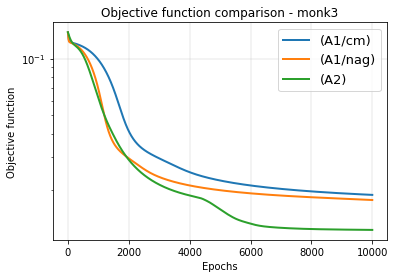

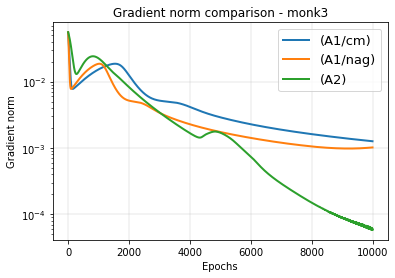

<Figure size 432x288 with 0 Axes>

In [9]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)

### Rate and gap comparison

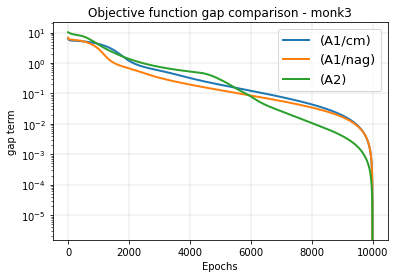

<Figure size 432x288 with 0 Axes>

In [12]:
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)

## CUP

In [10]:
debug = False
score = False
dataset = 'cup'
net_SGD, net_SGD_nest, net_Adam = report_stats(params, dataset, score=score, debug=debug)

100%|██████████| 10000/10000 [00:13<00:00, 721.03it/s]

----- SGD -----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False}
ep: 10000   | s: [5, 10] | b: 1066 | e: 0.01 | alpha:  0.3 | m:  0.5 | nesterovs_momentum: False
Grad: 4.20771e-02 | Loss: 4.16183e+00, 3.22065e+00 | Score: 0.939, 0.951
ended in: 13046.001, avg per ep: 1.3046001
total update: 5186.817999999965, avg updt: 0.5186817999999965
total ff: 30000, total ff time: 4207.381999999972, avg ff: 0.14024606666666575
total bp: 10000, total bp time: 2861.3170000000014, avg bp: 0.28613170000000016
total ev: 10000, total ev time: 7700.024999999967, avg ev: 0.7700024999999967

 

----- SGD nesterov-----
{'activation': 'logistic', 'alpha': 0.3, 'batch_size': None, 'hidden_layer_sizes': [5, 10], 'learning_rate_init': 0.01, 'max_iter': 10000, 'momentum': 0.5, 'solver': 'sgd', 'tol': 1e-08, 'verbose': False, 'nesterovs_momentum': True}
ep: 10

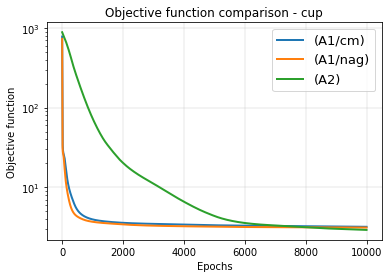

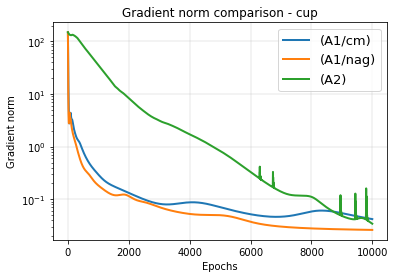

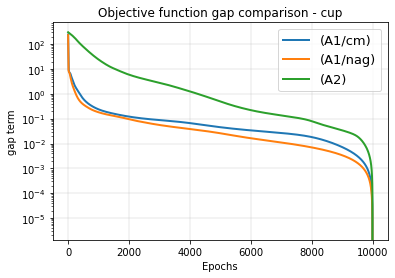

<Figure size 432x288 with 0 Axes>

In [11]:
report_plots(params, dataset, net_SGD=net_SGD, net_SGD_nest=net_SGD_nest, net_Adam=net_Adam, score=score)
report_gap_comp(dataset, net_SGD, net_SGD_nest, net_Adam, save=False)